In [1]:
# Import Libraries
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Define a function to extract audio features from an audio file
def extract_audio_features(file_path, n_mfcc=13, n_chroma=12, n_contrast=6, max_len=200):

    # Load the audio file; sr=None preserves the native sampling rate
    audio, sample_rate = librosa.load(file_path, sr=None)
    
    # Extract MFCC (Mel-frequency cepstral coefficients) features
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    # Pad or truncate the MFCC feature matrix to ensure consistent dimensions
    if mfcc.shape[1] < max_len:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_len - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    
    # Extract chroma features (chroma energy normalized; represents pitch class energy)
    chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate, n_chroma=n_chroma)
    # Pad or truncate the chroma feature matrix similarly for uniformity
    if chroma.shape[1] < max_len:
        chroma = np.pad(chroma, ((0, 0), (0, max_len - chroma.shape[1])), mode='constant')
    else:
        chroma = chroma[:, :max_len]
    
    # Extract spectral contrast (differences in amplitude across frequency bands)
    contrast = librosa.feature.spectral_contrast(y=audio, sr=sample_rate, n_bands=n_contrast, fmin=200.0)
    # Ensure spectral contrast matrix matches the desired shape (padding/truncating as needed)
    if contrast.shape[1] < max_len:
        contrast = np.pad(contrast, ((0, 0), (0, max_len - contrast.shape[1])), mode='constant')
    else:
        contrast = contrast[:, :max_len]
    
    # Combine extracted features by stacking them vertically
    features = np.vstack((mfcc, chroma, contrast))
    
    return features


In [3]:
# Directory containing audio files to process
audio_speech = 'AudioWAV'

# Lists to store extracted features and labels for each audio file
features = []
labels = []
for file_name in os.listdir(audio_speech):
    if file_name.endswith('.wav'):  # Process only .wav files
        file_path = os.path.join(audio_speech, file_name)
        # Extract label based on filename (file name pattern ####_SentenceID_EmotionID_ToneID)
        # Emotion Labels are: Anger (ANG), Fear (FEA), Disgust (DIS), Happy (HAP), Neutral (NEU), Sad (SAD))
        label = file_name.split('_')[2]  # pulling the 3rd value from file name which is the emotion ID
        # Extract feature vector for the current file
        feature_vector = extract_audio_features(file_path)
        features.append(feature_vector)
        labels.append(label)

# Convert lists to DataFrame for easier data handling
feat_labs = pd.DataFrame({'Features': features, 'Label': labels})

# print features
print(feat_labs)

# Inspect unique labels extracted from file names
unique_labels = sorted(set(labels))
print("Unique Labels Extracted from File Names:", unique_labels)

C:\Users\Donva\anaconda3\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


                                               Features Label
0     [[-589.8760375976562, -507.2122802734375, -465...   ANG
1     [[-494.1741027832031, -463.858154296875, -459....   DIS
2     [[-466.0972900390625, -458.12811279296875, -45...   FEA
3     [[-465.77593994140625, -436.8394470214844, -43...   HAP
4     [[-484.9637145996094, -454.3514099121094, -450...   NEU
...                                                 ...   ...
7437  [[-541.3533935546875, -512.3934326171875, -513...   DIS
7438  [[-500.56378173828125, -506.8985290527344, -51...   FEA
7439  [[-546.4652099609375, -513.5806274414062, -509...   HAP
7440  [[-549.4096069335938, -518.1360473632812, -514...   NEU
7441  [[-555.9723510742188, -515.941650390625, -507....   SAD

[7442 rows x 2 columns]
Unique Labels Extracted from File Names: ['ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD']


In [4]:
# Encode labels to numerical format for modeling
le = LabelEncoder()
labels = le.fit_transform(labels)

# Verify the mapping between numeric and descriptive labels
label_mapping = {index: label for index, label in enumerate(le.classes_)}
print("Label Mapping (Numeric to Descriptive):", label_mapping)

# Convert features and labels intp numpy arrays
X = np.array(features)
y = np.array(labels)

# Split the data: 60% training, 20% validation, 20% testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32, shuffle=True)

# Print the split sizes for verification
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Label Mapping (Numeric to Descriptive): {0: 'ANG', 1: 'DIS', 2: 'FEA', 3: 'HAP', 4: 'NEU', 5: 'SAD'}
Training set size: 4465
Validation set size: 1488
Test set size: 1489


In [9]:
# Define a neural network model class combining CNN and LSTM layers
# Define the CNN + LSTM model
class CNN_LSTM(nn.Module):
    def __init__(self, input_features, max_len, num_classes):
        super(CNN_LSTM, self).__init__()
        
        # CNN layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=(1, 1))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=(1, 1))
        self.pool = nn.MaxPool2d((2, 2))
        self.dropout = nn.Dropout(0.3)
        
        # Calculate the output dimensions after CNN layers
        cnn_out_height = input_features // 4  # Pooling reduces height by a factor of 2 twice
        cnn_out_width = max_len // 4  # Pooling reduces width by a factor of 2 twice
        lstm_input_size = 64 * cnn_out_height  # 64 channels * reduced height
        
        # LSTM layers
        self.lstm = nn.LSTM(input_size=lstm_input_size, hidden_size=128, num_layers=2, batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        # CNN layers
        x = x.unsqueeze(1)  # Add channel dimension for CNN (batch, 1, n_mfcc, max_len)
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        
        # Reshape for LSTM
        batch_size, _, height, width = x.size()
        x = x.view(batch_size, width, -1)  # (batch, sequence_length=width, features=channels*height)
        
        # LSTM layers
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Take the output from the last time step
        
        # Fully connected layer
        x = self.fc(x)
        return x

In [10]:
# Model parameters setup
input_features = X_train_tensor.size(1)  # Number of input features per time step
max_len = X_train_tensor.size(2)         # Sequence length (number of time steps)
num_classes = len(le.classes_)           # Number of output classes (emotions)

# Initialize the CNN-LSTM model, loss function, and optimizer
model = CNN_LSTM(input_features=input_features, max_len=max_len, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

# Training loop setup
num_epochs = 20  # Number of training epochs
for epoch in range(num_epochs):
    # Training phase
    model.train()  # Set model to training mode (enables dropout and batch normalization)
    running_train_loss = 0.0  # Track training loss

    for X_batch, y_batch in train_loader:
        # Forward pass
        outputs = model(X_batch)  # Model predictions
        loss = criterion(outputs, y_batch)  # Calculate training loss
        
        # Backward pass and optimization
        optimizer.zero_grad()  # Zero gradients to avoid accumulation
        loss.backward()        # Backpropagation
        optimizer.step()        # Update weights

        running_train_loss += loss.item()  # Accumulate training loss
    
    # Validation phase
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # Disable gradients for validation
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)  # Model predictions
            loss = criterion(outputs, y_batch)  # Calculate validation loss
            running_val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # Predicted class
            total_val += y_batch.size(0)  # Total samples in validation batch
            correct_val += (predicted == y_batch).sum().item()  # Correct predictions

    # Calculate losses and validation accuracy
    avg_train_loss = running_train_loss / len(train_loader)  # Average training loss
    avg_val_loss = running_val_loss / len(val_loader)        # Average validation loss
    val_accuracy = 100 * correct_val / total_val             # Validation accuracy

    # Print epoch summary
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.2f}%")

# Test the model on the hold-out test set
model.eval()  # Set model to evaluation mode
correct_test = 0
total_test = 0

with torch.no_grad():  # Disable gradients for testing
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)  # Model predictions
        _, predicted = torch.max(outputs, 1)  # Predicted class
        total_test += y_batch.size(0)  # Total samples in test batch
        correct_test += (predicted == y_batch).sum().item()  # Correct predictions

# Calculate and display test accuracy
test_accuracy = 100 * correct_test / total_test
print(f"Test Accuracy: {test_accuracy:.2f}%")


Epoch [1/20], Train Loss: 1.5416, Val Loss: 1.4753, Val Accuracy: 40.19%
Epoch [2/20], Train Loss: 1.4227, Val Loss: 1.4530, Val Accuracy: 41.26%
Epoch [3/20], Train Loss: 1.3914, Val Loss: 1.4252, Val Accuracy: 40.93%
Epoch [4/20], Train Loss: 1.3458, Val Loss: 1.3743, Val Accuracy: 45.56%
Epoch [5/20], Train Loss: 1.3201, Val Loss: 1.4865, Val Accuracy: 40.39%
Epoch [6/20], Train Loss: 1.3159, Val Loss: 1.4191, Val Accuracy: 43.48%
Epoch [7/20], Train Loss: 1.2671, Val Loss: 1.4237, Val Accuracy: 43.28%
Epoch [8/20], Train Loss: 1.2241, Val Loss: 1.3667, Val Accuracy: 45.56%
Epoch [9/20], Train Loss: 1.1445, Val Loss: 1.3511, Val Accuracy: 47.31%
Epoch [10/20], Train Loss: 1.1085, Val Loss: 1.3971, Val Accuracy: 47.04%
Epoch [11/20], Train Loss: 1.0306, Val Loss: 1.3840, Val Accuracy: 46.91%
Epoch [12/20], Train Loss: 0.9686, Val Loss: 1.4586, Val Accuracy: 44.62%
Epoch [13/20], Train Loss: 0.8843, Val Loss: 1.4776, Val Accuracy: 44.76%
Epoch [14/20], Train Loss: 0.8276, Val Loss: 1.

In [11]:
# Placeholder lists to store true and predicted labels
y_true = []
y_pred = []

# Switch model to evaluation mode
model.eval()
with torch.no_grad():
    # Use the test data loader to evaluate the model on the hold-out test set
    for X_batch, y_batch in test_loader:  
        outputs = model(X_batch)  # Get model predictions
        _, predicted = torch.max(outputs, 1)  # Extract the predicted class for each sample
        
        # Append true and predicted labels
        y_true.extend(y_batch.cpu().numpy())  # Convert true labels to numpy and add to list
        y_pred.extend(predicted.cpu().numpy())  # Convert predicted labels to numpy and add to list

# Convert lists to numpy arrays for evaluation
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Ensure that le.classes_ is a list of strings
print("le.classes_: ", le.classes_)
print("Type of le.classes_: ", type(le.classes_))
# Generate descriptive class names for classification report
class_names = [label_mapping[i] for i in range(len(label_mapping))]
print("Class Names for Evaluation:", class_names)


# Generate a classification report
report = classification_report(y_true, y_pred, target_names=class_names)  # Use the list of class names
print("Classification Report:")
print(report)


le.classes_:  ['ANG' 'DIS' 'FEA' 'HAP' 'NEU' 'SAD']
Type of le.classes_:  <class 'numpy.ndarray'>
Class Names for Evaluation: ['ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD']
Classification Report:
              precision    recall  f1-score   support

         ANG       0.60      0.53      0.57       255
         DIS       0.40      0.30      0.34       254
         FEA       0.39      0.30      0.34       254
         HAP       0.33      0.46      0.38       255
         NEU       0.38      0.44      0.41       217
         SAD       0.45      0.48      0.47       254

    accuracy                           0.42      1489
   macro avg       0.43      0.42      0.42      1489
weighted avg       0.43      0.42      0.42      1489



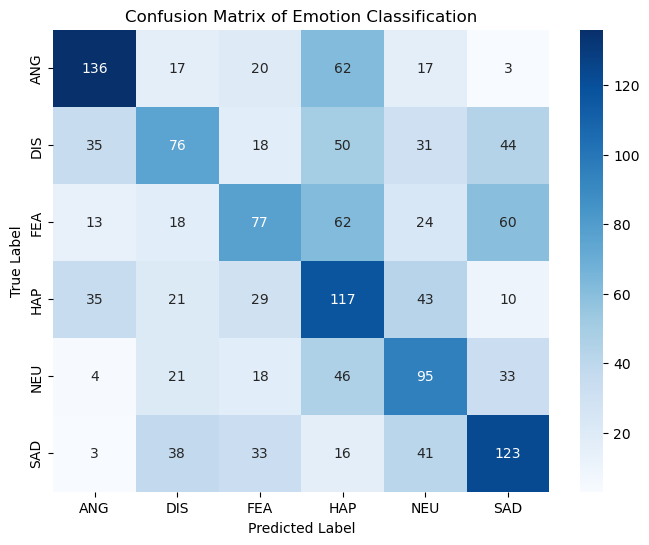

In [12]:
# Generate a confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)  # Use string class names for labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix of Emotion Classification")
plt.show()
